In [2]:
%pip install librosa

In [1]:
import torch.nn as nn
import os
import librosa
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader,random_split
import IPython
import re
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class CVAE2D(nn.Module):
    def __init__(self, input_channels=1, latent_dim=16, input_dim=(64, 64)):
        super(CVAE2D, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels
        self.input_dim = input_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=(2,2), padding=1),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=(2,3), padding=1),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=(2,3), padding=1),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=(2,3), padding=1),  # [batch, 256, 4, 4]
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        # Decoder: Deconvolutional layers
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=(2,3), padding=1, output_padding=(1,2)),  # [batch, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=(2,3), padding=1, output_padding=(1,2)),  # [batch, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=(2,3), padding=1, output_padding=(1,2)),  # [batch, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=(2,2), padding=1, output_padding=(1,1)),  # [batch, 1, 64, 64]
            nn.Sigmoid(),  # To ensure output is between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 256, 4, 4)  # Reshape to match the decoder input
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


# Define the loss function (reconstruction loss + KL divergence)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')  # Reconstruction loss (BCE for images)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD


def train_cvae2d(model, train_loader, test_loader, epochs=20, lr=0.001, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data[0]  # Assuming data comes as tuple (data, target), take only data
            data = data.to(device).float()

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()

            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(train_loader.dataset):.4f}")
        train_losses.append(train_loss / len(train_loader.dataset))

        if epoch % 100 == 0:
          with torch.no_grad():
              model.eval()
              test_loss = 0
              for batch_idx, data in enumerate(test_loader):
                  data = data[0]
                  data = data.to(device).float()

                  recon_batch, mu, logvar = model(data)
                  loss = loss_function(recon_batch, data, mu, logvar)
                  test_loss += loss.item()

          print(f"Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss / len(test_loader.dataset):.4f}")
        test_losses.append(test_loss / len(test_loader.dataset))

    # Plot training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Training complete!")


In [3]:
ls

sample_data/


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:32<00:00, 39.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [5]:
cd ..

/


In [6]:
cd /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz

/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz


In [7]:
rm jazz.00054.wav

In [8]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


In [9]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
len_dataset = 0
dataset_filenames = []
# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append([file_path, i])
print(len(dataset_filenames))

643356


In [10]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

In [11]:
#################################
# Parameters & Configuration
#################################
AUDIO_DIR = f'{path}/Data/genres_original/'    # Directory containing audio files
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64     # Frequency bins for the Mel-spectrogram
DURATION = 5.0   # Duration of each audio clip in seconds (30s is the entire clip)
GENRES = ['blues','classical','country','disco','hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']  # Example classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ConvRBM Hyperparameters
VISIBLE_CHANNELS = 1  # Spectrogram is treated as a single "image" channel
CD_K = 1    # Contrastive divergence steps
EPOCHS = 1000
BATCH_SIZE = 32

In [12]:
import os
import glob
import numpy as np
import librosa
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_dir, genres):
        self.data = []
        self.labels = []
        self._load_audio_files(audio_dir, genres)

    def _load_audio_files(self, audio_dir, genres):
        for i, genre in enumerate(genres):
            genre_path = os.path.join(audio_dir, genre)
            for fname in glob.glob(os.path.join(genre_path, "*.wav")):
                # Load audio
                audio, sr = librosa.load(
                    fname,
                    sr=SAMPLE_RATE,
                    duration=DURATION)
                # print("audio length", len(audio))

                # Compute Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=audio,
                    sr=SAMPLE_RATE,
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH,
                    n_mels=N_MELS)
                # Convert to log scale
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                # Normalize
                log_mel = (log_mel/85 + 1)/2

                # Append data and label
                self.data.append(log_mel)
                # print("appending data", log_mel.shape)
                self.labels.append(i)
                # print("appending label", i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert data and labels to PyTorch tensors
        mel_tensor = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0) # Adding singe channel dimension since it is grayscale
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_tensor, label_tensor

def get_dataloader(audio_dir, genres=GENRES, batch_size=BATCH_SIZE, shuffle=True):
    dataset = AudioDataset(audio_dir, genres)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def split_dataset(audio_dir=AUDIO_DIR, genres=GENRES, test_size=0.1, val_size=0.1, random_seed=14):
    # Create the full dataset
    dataset = AudioDataset(audio_dir, genres)
    print("dataset length", len(dataset))

    # Split indices for training, validation, and test sets
    total_size = len(dataset)
    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_seed)

    # Further split the training indices into training and validation
    train_indices, val_indices = train_test_split(
        train_indices, test_size=val_size / (1 - test_size), random_state=random_seed)

    # Create subsets
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    return train_subset, val_subset, test_subset

def get_dataloaders(audio_dir, genres=GENRES, batch_size=BATCH_SIZE, test_size=0.1, val_size=0.1, shuffle=True, random_seed=13):
    train_subset, val_subset, test_subset = split_dataset(
        audio_dir, genres, test_size=test_size, val_size=val_size, random_seed=random_seed)

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [14]:
train_loader, val_loader, test_loader = get_dataloaders(AUDIO_DIR, GENRES, batch_size=BATCH_SIZE)

dataset length 999


In [15]:
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Number of training batches: 25
Number of validation batches: 4
Number of test batches: 4


Epoch 1/100, Training Loss: 8669.4448
Epoch 1/100, Test Loss: 8201.2626
Epoch 2/100, Training Loss: 8092.0765
Epoch 3/100, Training Loss: 7986.0250
Epoch 4/100, Training Loss: 7944.3638
Epoch 5/100, Training Loss: 7916.8276
Epoch 6/100, Training Loss: 7903.2108
Epoch 7/100, Training Loss: 7894.9946
Epoch 8/100, Training Loss: 7889.4239
Epoch 9/100, Training Loss: 7884.4891
Epoch 10/100, Training Loss: 7880.6881
Epoch 11/100, Training Loss: 7876.2186
Epoch 12/100, Training Loss: 7872.9257
Epoch 13/100, Training Loss: 7869.4693
Epoch 14/100, Training Loss: 7867.7130
Epoch 15/100, Training Loss: 7865.7343
Epoch 16/100, Training Loss: 7865.3383
Epoch 17/100, Training Loss: 7864.4252
Epoch 18/100, Training Loss: 7862.9203
Epoch 19/100, Training Loss: 7861.9233
Epoch 20/100, Training Loss: 7860.8787
Epoch 21/100, Training Loss: 7859.7336
Epoch 22/100, Training Loss: 7859.1473
Epoch 23/100, Training Loss: 7858.1591
Epoch 24/100, Training Loss: 7857.5078
Epoch 25/100, Training Loss: 7857.4840


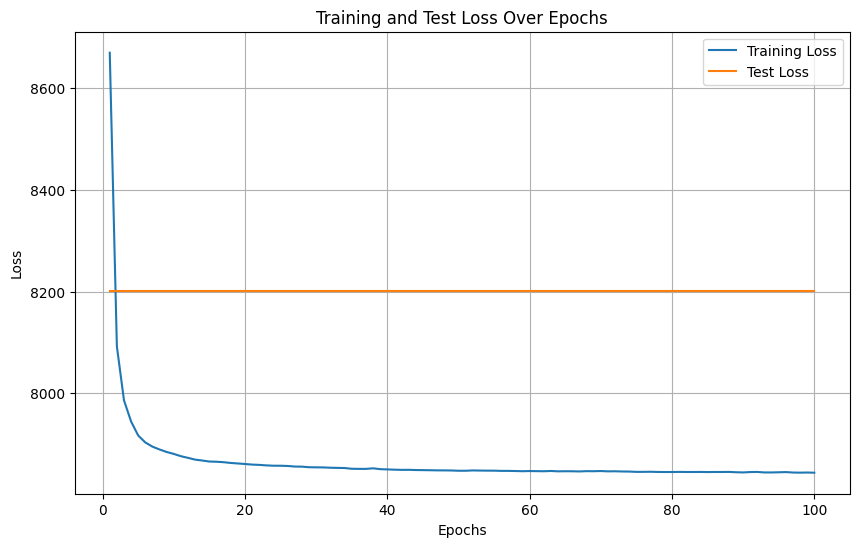

Training complete!


In [16]:
vae = CVAE2D(input_channels=VISIBLE_CHANNELS, latent_dim=32, input_dim=(64, 64))

train_cvae2d(vae, train_loader, test_loader, epochs=100, lr=0.001, device='cpu')

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate total number of samples
total_samples = 0
for data in train_loader:
    total_samples += data[0].size(0)

Z_train = torch.zeros((total_samples, 32))
labels_train = torch.zeros(total_samples)

current_index = 0
for i, data in enumerate(train_loader):
    current_batch_size = data[0].size(0)

    z = vae.encode(data[0])[0]  # get the mean not the variance

    Z_train[current_index:current_index + current_batch_size] = z
    labels_train[current_index:current_index + current_batch_size] = data[1]

    current_index += current_batch_size

In [18]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(Z_train.detach().numpy(), labels_train.detach().numpy())

LogisticRegression(max_iter=1000)

In [19]:
# Calculate total number of samples
total_samples = 0
for data in test_loader:
    total_samples += data[0].size(0)

Z_test = torch.zeros((total_samples, 32))
labels_test = torch.zeros(total_samples)

current_index = 0
for i, data in enumerate(test_loader):
    current_batch_size = data[0].size(0)

    z = vae.encode(data[0])[0]  # get the mean not the variance

    Z_test[current_index:current_index + current_batch_size] = z
    labels_test[current_index:current_index + current_batch_size] = data[1]

    current_index += current_batch_size

In [20]:
labels_predicted_test = clf.predict(Z_test.detach().numpy())

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
print(accuracy_score(labels_test.detach().numpy(), labels_predicted_test))

0.38
